### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Чтение данных
df = pd.read_csv('data.csv')
# df_train = pd.read_csv('uplift_data/uplift_train.csv', index_col='client_id')
# df_test = pd.read_csv('uplift_data/uplift_test.csv', index_col='client_id')

# Извлечение признаков
# df_features = df_clients.copy()
# df_features['first_issue_time'] = \
#     (pd.to_datetime(df_features['first_issue_date'])
#      - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# df_features['first_redeem_time'] = \
#     (pd.to_datetime(df_features['first_redeem_date'])
#      - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
#     - df_features['first_issue_time']
# df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)



In [2]:
import seaborn as sns

In [3]:
#conversion -> target, offer -> treatment
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [4]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [5]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [6]:
df['churn'] = df['recency'].apply(lambda x: 0 if x < 9.0 else 1)

In [7]:
df['history_log'] = np.log(df["history"])

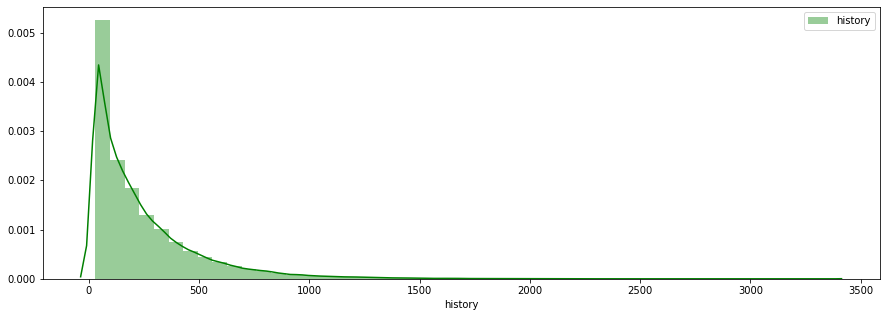

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
# sns.distplot(df['history_log'], color="Blue", label="history_log")
sns.distplot(df['history'], color="Green", label="history")
plt.legend()

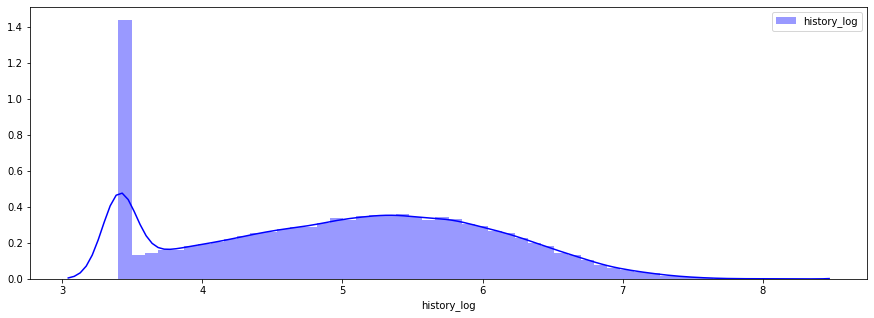

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.distplot(df['history_log'], color="Blue", label="history_log")
# sns.distplot(df['history'], color="Green", label="history")
plt.legend()

In [10]:
df['large_account'] = df['history'].apply(lambda x: 0 if x < 1000.0 else 1)

In [11]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,churn,history_log,large_account
0,10,142.44,1,0,Surburban,0,Phone,1,0,1,4.958921,0
1,6,329.08,1,1,Rural,1,Web,0,0,0,5.796301,0
2,7,180.65,0,1,Surburban,1,Web,1,0,0,5.196561,0
3,9,675.83,1,0,Rural,1,Web,1,0,1,6.515942,0
4,2,45.34,1,0,Urban,0,Web,1,0,0,3.814190,0
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0,1,4.659090,0
63996,5,38.91,0,1,Urban,1,Phone,1,0,0,3.661251,0
63997,6,29.99,1,0,Urban,1,Phone,1,0,0,3.400864,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0,0,6.315249,0


In [12]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,churn,history_log,large_account
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781,0.310031,4.995720,0.020438
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890,0.462510,1.028861,0.141492
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400864,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.169143,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.063291,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,5.785846,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.115500,1.000000


In [13]:
df.nunique()

recency             12
history          34833
used_discount        2
used_bogo            2
zip_code             3
is_referral          2
channel              3
treatment            2
target               2
churn                2
history_log      34833
large_account        2
dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=123)

In [15]:
treat_train = X_train['treatment']
X_train = X_train.drop('treatment', axis=1)

treat_test = X_test['treatment']
X_test = X_test.drop('treatment', axis=1)

cat_feats = df.select_dtypes(include=["object"]).columns.to_list()

models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [17]:
cat_feats

['zip_code', 'channel']

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, treat_train.shape, treat_test.shape

((51200, 10), (12800, 10), (51200,), (12800,), (51200,), (12800,))

одна модель с признаком коммуникации (S learner)

uplift@20%: 0.0897
uplift@10%: 0.1037


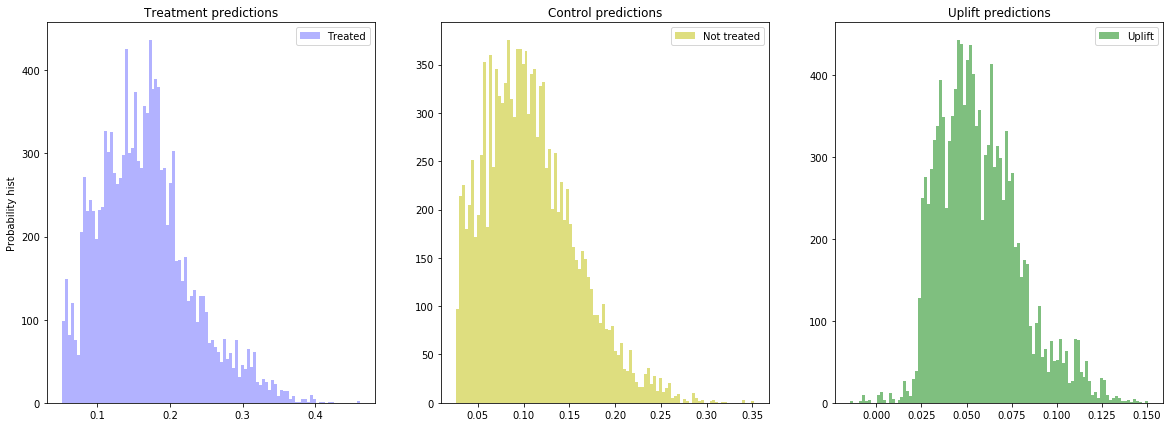

In [20]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})

uplift_sm = sm.predict(X_test)

sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score20:.4f}')

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score10:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score20)
models_results['uplift@10%'].append(sm_score10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [21]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.992915
1,treatment,17.017366
2,used_bogo,12.943347
3,recency,12.753373
4,zip_code,10.599241
5,channel,8.734191
6,used_discount,8.267517
7,history_log,7.574404
8,history,2.035802
9,large_account,0.081843


Модель с трансформацией таргета (трансформация классов п. 2. 1)

In [23]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})

uplift_ct = ct.predict(X_test)

ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score20)
models_results['uplift@10%'].append(ct_score10)

C:\Users\LMAXL\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


Вариант с двумя независимыми моделями

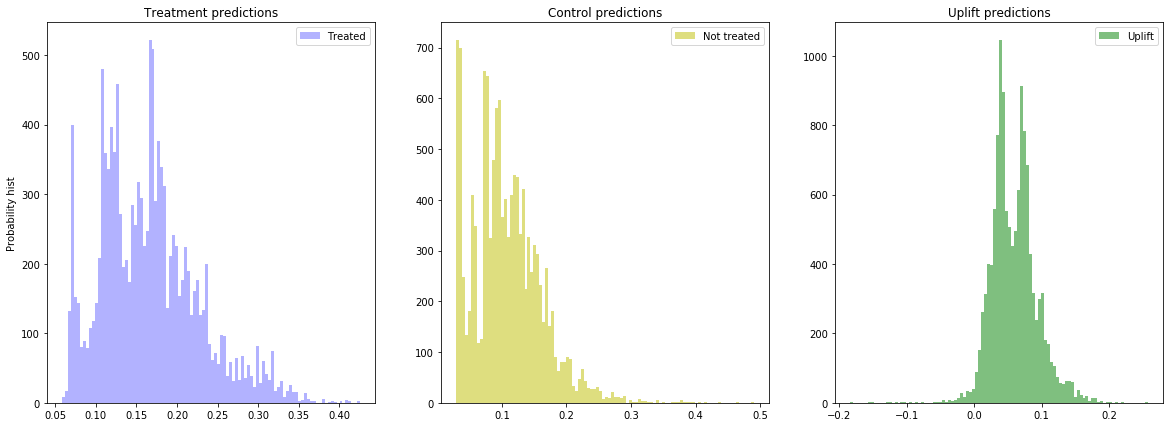

In [24]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_feats}, 
    estimator_ctrl_fit_params={'cat_features': cat_feats}
)

uplift_tm = tm.predict(X_test)

tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score20)
models_results['uplift@10%'].append(tm_score10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [25]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@20%,uplift@10%
1,ClassTransformation,0.109649,0.123635
2,TwoModels,0.097230,0.108284
0,SoloModel,0.089729,0.103677


#### Вариант с деревом решений

In [3]:
import causalml

In [5]:
from IPython.display import Image

In [6]:
%%time


uplift_model = causalml.inference.tree.UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = causalml.inference.tree.uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

AttributeError: module 'causalml' has no attribute 'inference'